# Collaborative Filtering with Goodbooks-10k Dataset 

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preperation
## Load the Book-Crossing Dataset

In [5]:
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"  # Book-Crossing ratings link 
data = pd.read_csv(url)

print("Dataset Sample:\n", data.head())
print("\nDataset Shape:", data.shape)

Dataset Sample:
    user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3

Dataset Shape: (5976479, 3)


 ## Preprocess the Dataset
 ### Drop unnecessary columns (if present)

In [7]:
print("\nUnique Users:", data['user_id'].nunique())
print("Unique Books:", data['book_id'].nunique())

# Filter out users with fewer than 5 ratings and books with fewer than 5 ratings
user_ratings = data.groupby("user_id").size()
data = data[data["user_id"].isin(user_ratings[user_ratings >= 5].index)]

book_ratings = data.groupby("book_id").size()
data = data[data["book_id"].isin(book_ratings[book_ratings >= 5].index)]


Unique Users: 53424
Unique Books: 10000


# Build the Collaborative Filtering Model
## Filter for a subset of users and movies with sufficient ratings

In [20]:
filtered_users = data["user_id"].value_counts().head(1000).index  # Top 1000 users with most ratings
filtered_movies = data["book_id"].value_counts().head(1000).index  # Top 1000 books with most ratings

filtered_data = data[(data["user_id"].isin(filtered_users)) & (data["book_id"].isin(filtered_movies))]
print(filtered_data)

         user_id  book_id  rating
2921         173       14       4
2922         173      782       4
2923         173      531       3
2924         173      763       4
2925         173      646       3
...          ...      ...     ...
5972259    37897       61       3
5972961    50976      136       1
5973536    13000      586       4
5974207    13000      190       4
5975119    25030      178       3

[113999 rows x 3 columns]


### Create a user-item matrix

In [25]:
user_item_matrix = filtered_data.pivot_table(index="user_id", columns="book_id", values="rating")
user_item_matrix = user_item_matrix.fillna(0)  # Fill missing ratings with 0

print("User-Item Matrix created successfully.")
print(user_item_matrix.head())

User-Item Matrix created successfully.
book_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
35        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
173       4.0   5.0   4.0   4.0   0.0   5.0   0.0   0.0   4.0   0.0  ...   
178       4.0   0.0   1.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   
274       0.0   0.0   0.0   5.0   5.0   0.0   5.0   4.0   0.0   5.0  ...   
314       5.0   0.0   3.0   0.0   4.0   5.0   0.0   0.0   0.0   0.0  ...   

book_id  1423  1434  1435  1465  1498  1526  1530  1566  1681  1739  
user_id                                                              
35        0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   3.0   0.0  
173       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
178       0.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0   0.0  
274       0.0   0.0   0.0   4.0   0.0   0.0   5.0   0.0   0.0   0.0  
314     

## Compute user similarity

In [26]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("\nUser Similarity Matrix Sample:\n", user_similarity_df.head())


User Similarity Matrix Sample:
 user_id     35        173       178       274       314       368       439    \
user_id                                                                         
35       1.000000  0.175233  0.139623  0.281263  0.115163  0.206987  0.256341   
173      0.175233  1.000000  0.229623  0.197621  0.190697  0.200482  0.231087   
178      0.139623  0.229623  1.000000  0.247410  0.150468  0.184142  0.239162   
274      0.281263  0.197621  0.247410  1.000000  0.059340  0.196999  0.314157   
314      0.115163  0.190697  0.150468  0.059340  1.000000  0.187798  0.183335   

user_id     588       725       946    ...     52895     52929     52956  \
user_id                                ...                                 
35       0.196525  0.196579  0.158189  ...  0.021663  0.052991  0.151612   
173      0.332710  0.286391  0.357371  ...  0.119171  0.129062  0.152775   
178      0.236218  0.167115  0.333840  ...  0.093419  0.104185  0.173704   
274      0.290020  

# Predict Ratings
## Function to predict ratings

In [27]:
def predict_ratings(user_item_matrix, user_similarity):
    mean_user_ratings = user_item_matrix.mean(axis=1).values.reshape(-1, 1)
    ratings_diff = (user_item_matrix - mean_user_ratings)
    pred_ratings = mean_user_ratings + user_similarity.dot(ratings_diff) / np.array(
        [np.abs(user_similarity).sum(axis=1)]).T
    return pred_ratings

## Predict ratings

In [28]:
predicted_ratings = predict_ratings(user_item_matrix, user_similarity)

### Convert to DataFrame for readability

In [30]:
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)
print("\nPredicted Ratings Sample:\n", predicted_ratings_df.head())


Predicted Ratings Sample:
 book_id      1         2         3         4         5         6         7     \
user_id                                                                         
35       1.935820  1.952348  1.066660  1.974127  1.662928  0.659742  1.785128   
173      2.292907  2.318469  1.365780  2.199877  1.784043  1.061118  1.889791   
178      2.150681  1.983334  1.021555  1.914184  1.585613  0.746256  1.852997   
274      2.046496  2.292161  1.220070  2.316608  1.972863  0.789280  2.211688   
314      2.460495  2.092560  1.324356  1.939470  1.617520  1.051555  1.756240   

book_id      8         9         10    ...      1423      1434      1435  \
user_id                                ...                                 
35       1.551103  1.307214  1.701905  ...  0.076195  0.249229  0.652150   
173      1.694865  1.532328  1.720214  ...  0.184851  0.302446  0.583879   
178      1.524128  1.218699  1.498075  ...  0.008408  0.144691  0.521152   
274      1.889284  1.468

# Recommend Top Books
## Recommend top N books for a given user

In [31]:
def recommend_books(user_id, num_recommendations=5):
    user_pred_ratings = predicted_ratings_df.loc[user_id]
    already_rated = user_item_matrix.loc[user_id]
    recommendations = user_pred_ratings[already_rated == 0].sort_values(ascending=False).head(num_recommendations)
    return recommendations

## Example: Recommend books for a specific user

In [37]:
user_id = user_item_matrix.index[15]
recommendations = recommend_books(user_id)
print(f"\nRecommendations for User {user_id}:\n", recommendations)


Recommendations for User 1185:
 book_id
2     1.920966
59    1.900383
4     1.862155
37    1.856330
7     1.726505
Name: 1185, dtype: float64


# Evaluate the Model
## Calculate RMSE

In [39]:
def calculate_rmse(predictions, actuals):
    # Ignore missing ratings
    predictions = predictions[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return np.sqrt(mean_squared_error(predictions, actuals))

## Evaluate RMSE

In [43]:
actual_ratings = user_item_matrix.values
rmse = calculate_rmse(predicted_ratings, actual_ratings)
print("\nRMSE of the model:", rmse)


RMSE of the model: 3.141714500468928


# Visualize Similarity

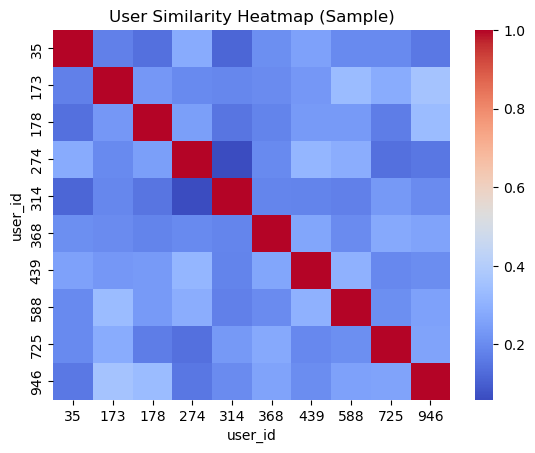

In [47]:
sns.heatmap(user_similarity_df.iloc[:10, :10], cmap="coolwarm", annot=False)
plt.title("User Similarity Heatmap (Sample)")
plt.show()